In [ ]:
!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'breastmnist'

download = True

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
info['task']

'binary-class'

In [ ]:
n_channels, n_classes

(1, 2)

In [ ]:
info['label'].values()

dict_values(['malignant', 'normal, benign'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
# define a simple CNN model

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)



        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


In [ ]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    y_pred = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)



            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
            preds = torch.argmax(outputs, dim=-1)
            preds = preds.reshape(-1, 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            y_pred = torch.cat((y_pred, preds), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        y_pred = y_pred.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

    return y_true, y_pred


print('==> Evaluating ...')
metrics = test('train')
metrics1 = test('test')

==> Evaluating ...
train  auc: 0.756  acc:0.731
test  auc: 0.732  acc:0.731


In [ ]:
# Compute precision, recall, F1
precision = precision_score(metrics[0], metrics[1], average='binary')
recall = recall_score(metrics[0], metrics[1], average='binary')
f1 = f1_score(metrics[0], metrics[1], average='binary')

print(f"Precision: {precision:.8f}")
print(f"Recall:    {recall:.8f}")
print(f"F1 Score:  {f1:.8f}")

Precision: 0.73076923
Recall:    1.00000000
F1 Score:  0.84444444


In [ ]:
# Compute precision, recall, F1
precision = precision_score(metrics1[0], metrics1[1], average='binary')
recall = recall_score(metrics1[0], metrics1[1], average='binary')
f1 = f1_score(metrics1[0], metrics1[1], average='binary')

print(f"Precision: {precision:.8f}")
print(f"Recall:    {recall:.8f}")
print(f"F1 Score:  {f1:.8f}")

Precision: 0.73076923
Recall:    1.00000000
F1 Score:  0.84444444


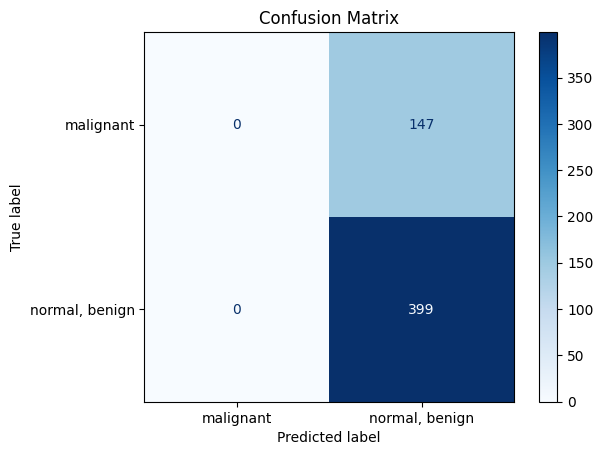

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Example true and predicted labels
#y_true = np.array([0, 1, 0, 1, 0, 1, 1, 0])
#y_pred = np.array([0, 0, 0, 1, 0, 1, 1, 1])

# Compute confusion matrix
cm = confusion_matrix(metrics[0], metrics[1])

# Optional: define class names
class_names = info['label'].values()

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

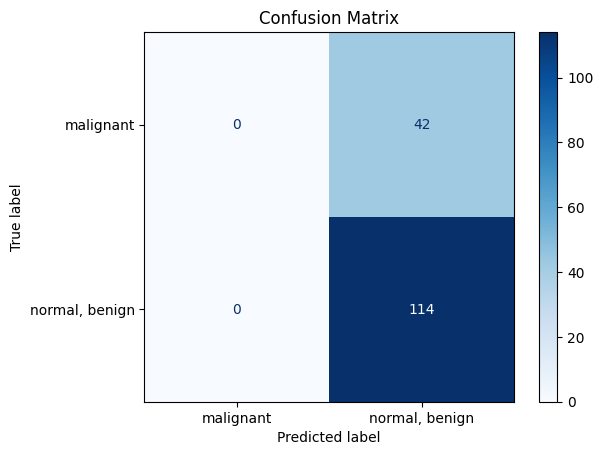

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(metrics1[0], metrics1[1])

#Define class names
class_names = info['label'].values()

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()